In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from motion_planning_utils import *
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly
import pyclipper
from pyscipopt import Model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project 4 - Motion Planning

### Introduction to Trajectory Optimization
- Introduce dynamics equations As + Bu = z
- Single obstacle encoding as constraints
    - Demonstrate creating a convex polygon bound
    - Show constraint formulation for OR constraints using big M notation
- Speed limit
    - Quadratic constraint on s'

## Robot Dynamics

In this part, we will incorporate robot dynamics using a discrete time model. The initial location, goal locations, the geometry of system and obstacles, and vehicle speed limits are the inputs. We ignore acceleration constraints, and will solve an optimization problem to minimize distance. We will simplify the problem by treating the robot as a point mass as well. 

Under these assumptions, a generalized dynamic equation can be written in the form:

$$\begin{array}{c}
& s_{t+1} = A_ds_t + B_du_t \\\
\end{array}$$

where:
- $s_t$ is state (postion and velocity) of the robot at time step $t$
- $A_d$ describes the dynamics relationship between position and velocity
- $B_d$ describes the dynamics relationship between control input and velocity
- $u_t$ is the control input at time step $t$
- $\Delta t$ is the time step size within total time $T$

In our simplified robot dynamics system, we will ignore control inputs and model dynamics as a function of position and time only. The maximum velocity will be formulated as a constraint on position variables at consecutive time steps. We can therefore system dynamics to be of the form:

$$\begin{array}{c}
& s_{t+1} = A_ds_t \\\
\end{array}$$

We can translate this equation into the matrix form:

$$  \begin{pmatrix}x_{t+1}\\y_{t+1}\end{pmatrix} = \begin{pmatrix}1&0& \bigtriangleup t &0\\0&1&0&\bigtriangleup t\end{pmatrix}  \begin{pmatrix}x_{t}\\y_{t}\\\dot{x}_{t}\\\dot{y}_{t}\end{pmatrix}$$


## Modeling the problem using a mathematical programming formulation

### Choosing Decision Variables
$$
\begin{array}{c}
x_t \text{ is the x-position at time step} i \text{ for } i \in [0,1,...,T]\\ 
y_t \text{ is the y-position at time step} i \text{ for } i \in [0,1,...,T]\\ 
\end{array}
$$


### Designing an Objective Function
Since the goal is to minimize distance traveled, our objective function will seek to minimize the cumulative distance traveled during each consecutive time step. The distance between any two time steps $t-1$ and $t$ is given by:

$$
\begin{array}{c}
\sqrt{(x_t - x_{t-1})^2 + (y_t - y_{t-1})^2}\\  
\end{array}
$$

In order to remove the complicating square-root from our objective function, we can instead minimize the square of distance, which gives us the following objective function:

$$
\begin{array}{c}
\text{OBJ: min}_t  \sum_1^T{(x_t - x_{t-1})^2 + (y_t - y_{t-1})^2}\\  
\end{array}
$$





### Modeling Maximum Velocity Constraint
Since our system is discretized into constant-duration time steps $\Delta t$, we can model coordinate component velocity as the change position at any time step t:

$$
\begin{array}{c}
\dot{x} = (x_t - x_{t-1})/\Delta t\\
\dot{y} = (y_t - y_{t-1})/\Delta t\\
\\
\text{and then the square of velocity becomes:}\\
\\
v^2 = [(x_t - x_{t-1})^2 + (y_t - y_{t-1})^2] / \Delta t^2\\
\end{array}
$$

$$
\begin{array}{c}
\text{If } u \text{ is the maximum velocity permitted, then } \lVert v \rVert \le u\text{, so our constraint can be written as: } \\
\\
(x_t - x_{t-1})^2 + (y_t - y_{t-1})^2 \le v^2 \Delta t^2 \quad \forall t\\
\end{array}
$$

Note that this constraint makes complicates the problem from a numerical solving efficiency standpoint -- the quadratic constraint brings us into the realm of Mixed-Integer Quadratically-Constrainted Programming (MIQCP)

### Encoding obstacles as constraints

Since all the obstacles in this problem are stationary, we can easily encode convex polygonal obstacles using linear constraints. Concave shape can be dealt with by chopping them into multiple convex objects, or by setting a convex boundary that encompasses the entire shape.

<img src="simple_sq_obs.png" style="width:50%;"/>

In the example scenario above, the obstacle is a rectangle shaped by $[x_{min}, x_{max}]$ and $[y_{min}, y_{max}]$. The positional constraint ensuring the obstacle is avoided can be expressed by: 

$$\begin{array}{l}
& \forall t  \in [1,2,3,..., T]:\\
& x_t \leq x_{min}\\
\text{or} & x_t \geq x_{max}\\
\text{or} & y_t \leq y_{min}\\
\text{or} & y_t \geq y_{max}\\
\end{array}$$

However, to make these constraints useful in solving a linear program, we need to reformulate the constraints to get rid of the "OR" statements and convert them to "AND" statements. To do this, we introduce the notion of the binary variable $z_{j,k}$:  

$$\begin{array}{l}
&& z_{j,k} \in [0,1]\\
&\text{where} & j \in [1,2,3,...J]\\
 && k \in [1,2,3,...K_j]\\
 && J \text{ is the number of polygon obstacles}\\
 && k \text{ is the index of each side of polygon obstacle j with $K_j$ total sides}\\
\end{array}$$

The binary variable $z_{j,k}$ is known as a _slack_ variable. A _slack_ variable allows us to transform and inequality into an equality, or in this case, an "OR" statement into an "AND" statement. For example, take the following inequality:

\begin{equation}
\bf{A}x \leq b
\end{equation}

We introduce the slack variable $z \geq 0$ which allows us to transform the above inequality into the following equality:

\begin{equation}
\bf{A}x + z = b
\end{equation}

Because $z$ can compensate for the "slack" between b and $\bf{A}x$ and make it so that $\bf{A}x + z$ is always equal to $b$.

Therefore, for our simple rectangle example, to transform the "OR" statements into "AND" statements, we use $z_{i,k}$ together with an arbitrarily large positive number $M$ (referred to as "Big-M" notation").

$$\begin{array}{l}
& \forall t \in [1,2,..., T]: \\
& x_t \leq x_{min} + M z_{1,1} \\
\text{and} & -x_t \leq -x_{max} + M z_{1,2} \\
\text{and} & y_t \leq y_{min} + M z_{1,3} \\
\text{and} & -y_t \leq -y_{max} + M z_{1,4} \\
\text{and} & \Sigma_{k=1}^{4} z_{j,k} \leq 3 \\
\end{array}$$


For example, $z_{j,1}=0$ if $x_t \leq x_{min}$. If $x_t \gt x_{min}$, then $z_{j,1}=1$ and since $M$ is a large positive number, we satisfy the constraint that $x_t \leq x_{min} + M z_{j,1}$. In order to classify a position $(x_t,y_t)$ as within obstacle $j$, then $\Sigma_{k=1}^{4} z_{j,k} = 4$ which has the same meaning as all of the "OR" statements in the previous section being false.


## Generalizing constraints for a n-sided polygon
The extension of the constraint enumeration to an obstacle shaped as a n-sided polygon is fairly trivial; the number of per-obstacle constraint equations is always $n+1$ with the last constraint equation resembling:
$$\Sigma_{k=1}^{n} z_{j,k} \leq n-1$$

The challenge in extending the obstacle encoding problem to obstacles shaped as n-sided polygons is the fact that an edge of the obstacle could _not_ be orthogonal to either the environment's X or Y axes. 

To begin, each polygon will have $n$ sides. We will denote each side with a pair of coordinates that correspond to the two vertexes that define the edges of the side; therefore, side $n_k = \{(x_{j,k},y_{j,k}),(x_{j,k'},y_{j,k'})\}$ such that $k \in [1,2,..n], k \neq k'$. From here, we can define a line segment for each side of the polygon

$$y_{j,k} = A_{j,k} x_{j,k} + b_{j,k}$$

Where $A_{j,k}$ is the slope of each side $l$. We can calculate $A_{j,k}$ by

$$A_{j,k} = \frac{y_{j,k'}-y_{j,k}}{x_{j,k'}-x_{j,k}}\quad s.t.\quad x_{j,k'}-x_{j,k} \neq 0\quad and \quad y_{j,k'}-y_{j,k} \neq 0$$

and calculate $b_{j,k}$ by substituting a point along the side for the values $(x_{j,k},y_{j,k})$ and solving for $b_{j,k}$. If $x_{j,k'}-x_{j,k} = 0$ or $y_{j,k'}-y_{j,k} = 0$, the side is parallel to the y-axis and x-axis, respectively. In these cases, the constraint equation for the side follows from the previous section. All sides that are not orthogonal to an axis can be represented by the following constraint equation:

$$y_{t} \leq A_{j,k}x_t + b_{j,k} + M z_{j,k}$$

Where $z_{j,k}$ and $M$ carry forward from the previous section. Therefore, the full set of constraint equations for sides of a rectangle whose sides are not orthogonal to either the x-axis or y-axis can be described by the following:

$$\begin{array}{l}
&\forall i \in [1,2,...,N]:\\
 & y_t \leq A_{j,1}x_{t} + b_{j,1} + M z_{j,1}\\
\text{and} & -y_t \geq -(A_{j,2}x_{t} + b_{j,2}) + M z_{j,2}\\
\text{and} & y_t \leq A_{j,3}x_{t} + b_{j,3} + M z_{j,3}\\
\text{and} & -y_t \geq -(A_{j,4}x_{t} + b_{j,4}) + M z_{j,4}\\
\text{and} & \Sigma_{k=1}^{4} z_{j,k} \leq 3\\
\end{array}$$

## Simple Robot Path Planning - Single Obstacle

We'll start by considering a simplified version of our ultimate problem, and examine constraint-based path planning throgh a single-obstacle environment to reach a single goal. In an 8x8 unit environment, we define our problem conditions as follows:

- Robot Start Point: `(1,1)`
- Goal Region: Rectangle region bounded by `[(6,6), (6,7), (7,7), (7, 6)]`
- Obstacles: Single obstacle bounded by `[(3,2), (2,6), (4,5), (6,3)]`

Our goal will be to minimize distance traveled.

Run the code in the next cell to preview the starting environment.



(5.5, 5.5)


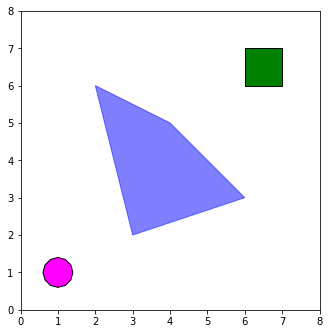

In [14]:
# Sample Problem
obstacles = [(3,2), (2,6), (4,5), (6,3)]
start = (1,1)
goal = [(6,6), (6,7), (7,7), (7, 6)]

env = Environment(None)
env.add_obstacles([Polygon(obstacles)])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.4, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, goal_region,'green')

In order to simplify the problem, we would like to treat our robot as a point object. To do this, we add a buffer, equal to the robot's radius, to every obstacle in the environment. This allows us to consider the robot as a point, rather than a moving area, and still take into account the robot's size to avoid collision with obstacles. 

To make this easy, we'll use the `pyclipper` package to create the buffer. The example code below performs this task for our example environment and obstacle, using functions defined in the `motion_planning_utils` file:

(5.5, 5.5)
Buffered Obstacle Vertices: 
 [[[6.3702459167689085, 2.9125967952422798], [4.118471829220653, 5.164370882790536], [1.7005063081160188, 6.373353643342853], [2.8583532432094216, 1.7419659039005637]]]


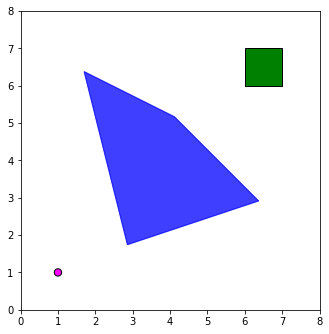

In [16]:
# Redefine obstacles with radius of droid; treat droid as a point robot
buff_obs = grow_obstacles(obstacles)
plot_env([Polygon(buff_obs[0])], start, goal, bounds)
print('Buffered Obstacle Vertices: \n', buff_obs)

## Obstacle Constraint Formulation Example

The code block below shows a polygon with sides that are orthogonal to the x-axis and y-axis as well as sides that are not orthogonal. Feel free to change the points in order to see whether they fall inside or outside of the polygon.

(5.5, 5.5)
Point 1 is NOT in obstacle 1
Point 2 IS in obstacle 1


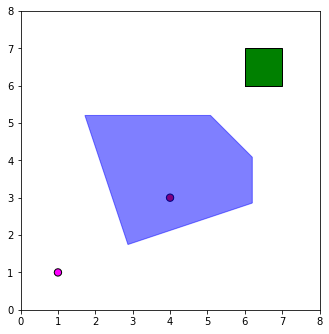

In [24]:
# Change obstacle points and start point at will
obs = ([(3,2), (2,5), (5,5),(6,4),(6,3)])
start = (1,1)
other = (4,3)

# DO NOT Change Below Here
pco = pyclipper.PyclipperOffset()
pco.MiterLimit = 10
pco.AddPath(pyclipper.scale_to_clipper(obs), pyclipper.JT_MITER, pyclipper.ET_CLOSEDPOLYGON)
buff_obs = pyclipper.scale_from_clipper(pco.Execute(pyclipper.scale_to_clipper(.2)))

env = Environment(None)
env.add_obstacles([Polygon(buff_obs[0])])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.1, resolution=3)
other_point = Point(other).buffer(0.1, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, other_point,'red')
plot_poly(ax, goal_region,'green')
points = (start, other)
numObs = len(env.obstacles)
for p in range(0,len(points)):
    point = points[p]
    for i in range(0,numObs):
        obstacle = env.obstacles[i]
        vertexes = list(obstacle.exterior.coords)
        numSides = len(vertexes)-1
        t = []
        x_center = 0
        y_center = 0
        for vertex in range(0,numSides):
            x_center = x_center + vertexes[vertex][0]
            y_center = y_center + vertexes[vertex][1]
        x_center = x_center/numSides
        y_center = y_center/numSides
        for vertex in range(0,numSides):
            x = vertexes[vertex][0]
            y = vertexes[vertex][1]
            num = vertexes[vertex+1][1] - vertexes[vertex][1]
            den = vertexes[vertex+1][0] - vertexes[vertex][0]
            if(den == 0):
                if(x_center < x):
                    t.append(point[0]<x)
                elif(x_center > x):
                    t.append(point[0]>x)
            else:
                A = (num/den)
                b = y-A*x
                if(y_center < A*x_center + b):
                    t.append(point[1] < A*point[0]+b)
                elif(y_center > A*x_center + b):
                    t.append(point[1] > A*point[0]+b)
        if(False not in t):
            print('Point %d IS in obstacle %d'%(p+1,i+1))
        else:
            print('Point %d is NOT in obstacle %d'%(p+1,i+1))
#should print out True, True, True, False, False. Goes around sides counterclockwise starting at vertical line.


In [ ]:
### Code here to automatically generate constraints from a list of lists that each define convex polygon vertices
# TODO
###

## Constraint Encoding Using PySCIPOpt Interface and SCIP Solver

After constructing the path planning problem as a MIQCP problem, we must encode the variables, objective function, and constraints and feed this into a solver. [PySCIPOpt](https://github.com/SCIP-Interfaces/PySCIPOpt) is a commonly-used python interface for the open-source [SCIP Solver](https://scip.zib.de/). 

The underlying outline is: 
 - Specify variables
 - Specify contraints over these variables
 - Construct a model with the constraints
 - Construct the solver using that model
 - Call `solve()` and extract results from variables using `get_value()`
 
As the variables and constraints are already defined above, the following section provides and example encoding of our trivial problem with a single obstacle.

The constructs of the problem are splitted into 3 parts: variables, constraints, and model.

In [19]:
## Some codes to solve the problem

## To define a model
# model = Model()

## Add constraints
#model.add(constraints)

## load solver
# solver = model.load('solver_name')

## Attempt to solve the problem
# solver.solve()

## To generate solutions:
# solver.startNewSearch()
# while solver.getNewSolution():
#     #do something 

#Results will be stored in teh Variable objects.

### **Solver Selection**

Since the problem contains quadratic constraints, we should select specific solver to solve the problem. Two possbile solvers are SCIP and Gurobi. 

Gurobi Optimizer is the the fastest and most powerful mathematical programming solver available for LP, QP and MIP (MILP, MIQP, and MIQCP) problems. But the problem is that Gurobi is not open-source.

SCIP is currently one of the fastest non-commercial solvers for mixed integer programming (MIP) and mixed integer nonlinear programming (MINLP). It is also a framework for constraint integer programming and branch-cut-and-price. It allows for total control of the solution process and the access of detailed information down to the guts of the solver.

Both the two solvers are fast and easy to implement with Numberjack. And the codes are pretty the same. We will choose one later, which serves better for the task in the project or relates to better results.  

In [13]:
# testing using SCIP via PyScipOpt
model = Model("Example")  # model name is optional

x = model.addVar("x")
y = model.addVar("y", vtype="INTEGER")
model.setObjective(2.2*x + 3*y)
model.addCons(2*x - y*y >= 5)
model.optimize()
sol = model.getBestSol()
print("x: {}".format(sol[x]))
print("y: {}".format(sol[y]))

x: 2.5
y: -0.0


### Space Station Problem Introduction
- Go through same steps as above
- Introduce multi-vehicle problem
    - Collision avoidance
    - Each waypoint visited by only one vehicle

In the real space station problem, it is a little different from the simplified problem above. The number of robots is bigger than 1, which means that we need to add dynamic equations and constrait equations for each robot. One of the big change here is the non-collision constraint, which can be formalized by that all the robot pairs keep a minimum distance accoding their own coordination. But the process to solve the problem is relatively similar as the one we use in the simplified problem.

In [ ]:
# Code here to determine constraint parameters

### Encoding of Problem - MIQCP

Since the speed limit is given, the distance traveled in a given time step is a quadratic constraint. 

Thus the whole problem can be encoded as a motion planning problem based on MIQCP with the constriant of speed limitation, time limitation (termination constraint), non-collision constraint, obstacle constraint with the objective function of time to finish the whole task. 

In [14]:
# Encoding of problem using PySCIPOpt

## Conclusion
- Discussion of results
- Considerations for added complexity (multi-vehicle, fixed arrival time, etc)